Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

In [13]:
!pip install --upgrade --quiet git+https://github.com/datacommonsorg/api-python.git@stable-1.x

Welcome! This is a Colaboratory notebook by the [Data Commons](https://datacommons.org/) team. If you are new to Colaboratory, please check out their [FAQ](https://research.google.com/colaboratory/faq.html) and [Tutorial](https://colab.sandbox.google.com/notebooks/basic_features_overview.ipynb).

In [0]:
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from google.colab import drive

# Case Study: Effects of Socio-contextual Factors on Student Achievement

The landmark [Equality of Educational Opportunity](https://hub.jhu.edu/magazine/2016/winter/coleman-report-public-education/) study by James S. Coleman
first documented the "achievement gap" in 1966, reporting that "the inequalities imposed on children by their home, neighbourhood and peer environment are carried along to become the inequalities with which they confront adult life at the end of school" (p. 325). Millions of [research papers](https://scholar.google.com/scholar?q=achievement+gap) have been written on the
topic since, similarly reporting  that socio-economic factors of students _and their peers_ negatively correlate with student achievement ([[1]](https://www.epi.org/publication/education-inequalities-at-the-school-starting-gate/),[[2]](http://www.senate.mo.gov/jced/Public_School_Study.pdf),[[3]](https://pdfs.semanticscholar.org/7996/39b0938b9568c4ce5f36fc901a6075560623.pdf),...).

The [Stanford Education Data Archive (SEDA)](https://browser.datacommons.org/kg?dcid=dc/m739173&db=) datasets report general information about school districts and counties as well as school district and county level test scores disaggregated by factors such race, gender, and grade. Furthermore, SEDA provides multiple normalized test score metrics so that it is easy to directly correlate academic achievement against different years, grades, and locations. 

The [FBI](https://browser.datacommons.org/kg?dcid=dc/fx0lj33&db=)'s Uniform Crime Reporting Program provides crime incident data; the [US Census](https://browser.datacommons.org/kg?dcid=dc/xby0xq2&db=) provides data on poverty, nativity, educational attainment, gender, race, and income; and the [US Bureau of Labor Statistics](https://browser.datacommons.org/kg?dcid=dc/p/820mxx8ejlrj7) provides data on employment and population. Although these sources for socio-economic data come from different datasets across different government agencies with different storage formats, Data Commons surfaces each of these in a single, uniform knowledge graph. We will demonstrate how to take advantage of this unified graph to correlate student achievement with socio-contextual factors from various sources.

Before we begin, we need to import the `datacommons` library.

In [0]:
# Import the Data Commons library
import datacommons as dc

We will also need to assign an API key to the library. See the [Analyzing Statistics in Data Commons Using the Python API](https://colab.research.google.com/drive/1ZNXTHu3J0W3vo9Mg3kNUpk0hnD6Ce1u6#scrollTo=ijxoBhFHjo3Z) to see how to set this up for a Colab Notebook.

In [16]:
# Mount the Drive
drive.mount('/content/drive', force_remount=True)

# REPLACE THIS with the path to your key if copying this notebook.
key_path = '/content/drive/My Drive/DataCommons/secret.json'

# Read the key in and provide it to the Data Commons API
with open(key_path, 'r') as f:
  secrets = json.load(f)
  dc.set_api_key(secrets['dc_api_key'])

Mounted at /content/drive


## Case Study Part 1: Crime Rate vs Student Achievement
In this section, we will look at how crime rate correlates with academic achievement at the county level. In Data Commons, academic achievement is reported at the county level, while the crime data is reported at the city level. We will aggregate city crime data to get the effective county crime rate. To keep things simple, we will focus on the academic achievement of 3rd, 5th, and 8th grade students in math, and use the year 2015. Academic achievement will be measured by the [cohort-scale metric](https://stacks.stanford.edu/file/druid:db586ns4974/SEDA_documentation_v21.pdf), a scoring metric from SEDA that allows for direct comparison across different grades, years, school districts, and counties. It is "standardized by dividing by the national grade-subject-specific standard deviation for a given cohort in our data".

This process will be split into three parts:
1. Find all counties and cities located in the United States
1. Retrieve statistics
  - about academic achievement of each county
  - about crime rate of each county
3. Visualize the statistics and analyze correlation with linear regression

### Step 1: Find all counties and cities located in the United States

To begin, we initialize a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).Since we are looking for all counties and cities in the United States, we "jumpstart" our empty DCFrame instance by querying for the entity "United States".

To do this, we first head to the Data Commons Browser and [search for "United States"](https://browser.datacommons.org/search?query=united+states). We find the [United States entity](https://browser.datacommons.org/kg?dcid=country/USA) and see that its Data Commons Identifier (`dcid`) is "country/USA", and its type (`typeOf`) is "Country". The dcid is how Data Commons refers to an entity and will allow us to query for other statistics about the entity, such as its name, or places contained in it.

Let's create the first column in our DCFrame, called something reasonable like "usa_dcid", with type "Country", and populated with the dcid we found: `country/USA`.

In [0]:
# Start with the USA node
frame = pd.DataFrame({'usa_dcid': ['country/USA']})

Now, we can proceed to querying for all counties and cities within `country/USA`. We can use the **`get_places_in`** function. The `get_places_in` function gives us the dcids of all places of a specified type contained inside places in an existing (`seed`) column. This place containment data comes from the [GeoNames](https://www.usgs.gov/core-science-systems/national-geospatial-program/geographic-names) database.

First, we find all the counties in the USA, and then find all cities within each county.

Each of these queries can take up to a minute to run.

**Tip**: to see the documentation for the arguments of each method presented in this Colab, hover over the method call (in this case, hover your mouse over "`get_places_in`"). You'll need to have run the first code cell above.

In [0]:
# Get all counties in the United States
frame['county_dcid'] = dc.get_places_in(frame['usa_dcid'], 'County')
frame = dc.flatten_frame(frame)

In [0]:
# Get all cities in the United States
frame['city_dcid'] = dc.get_places_in(frame['county_dcid'], 'City')
frame = dc.flatten_frame(frame)

**Note:** currently, Data Commons does not distinguish between city, town, village, borough, or Census-Designated Place. This means despite specifying `new_col_type='City'`, we are getting non-cities.

Here is what our DCFrame looks like now. We started with the USA node and expanded to include all counties and cities in the USA. So far, we've done this using just one data source, but hang tight.

In [20]:
frame.sample(5)

,usa_dcid,county_dcid,city_dcid
24590,country/USA,geoId/45059,geoId/4574995
19472,country/USA,geoId/37163,geoId/3733640
25682,country/USA,geoId/48021,geoId/4805000
7174,country/USA,geoId/17113,geoId/1775822
2247,country/USA,geoId/06023,geoId/0605262


### Step 2A: Retrieve county academic achievement statistics

Data Commons represents SEDA academic achievement statistics in the graph using [StatisticalPopulation](http://schema.datacommons.org/StatisticalPopulation) and [Observation](http://schema.datacommons.org/Observation) types. A __StatisticalPopulation__ models entities of the same type with a set of constraints.

For example, 3rd graders in Santa Clara County studying math can be expressed as a StatisticalPopulation with the following: "the population of students where their grade level is 3rd grade, are located in Santa Clara County, and are enrolled in the school subject math."

[Here](https://browser.datacommons.org/kg?dcid=dc/p/e0406p1tg2szf) is an example population we'd like to retrieve.

We express these constraints using arguments to the `get_populations` function: `population_type`, `schoolGradeLevel`, `schoolSubject`. `get_populations` will return a pandas Series with the dcid of each population located in the counties whose dcids are inside the `seed_col_name`. To see what values to use in these constraints, we can check the `rangeIncludes` of these properties. For example, [`schoolGradeLevel`](https://browser.datacommons.org/kg?dcid=schoolGradeLevel) has `rangeIncludes` of [`NCESGradeEnum`](https://browser.datacommons.org/kg?dcid=NCESGradeEnum), from which we learn that we can specify `schoolGradeLevel="NCESThirdGrade"`, etc.

In [21]:
# get the student populations
frame['third_grade_math_population'] = dc.get_populations(
    frame['county_dcid'],
    population_type='Student',
    constraining_properties={
        'schoolGradeLevel': 'NCESThirdGrade',
        'schoolSubject': 'Mathematics',
    }
)
frame['fifth_grade_math_population'] = dc.get_populations(
    frame['county_dcid'],
    population_type='Student',
    constraining_properties={
        'schoolGradeLevel': 'NCESFifthGrade',
        'schoolSubject': 'Mathematics',
    }
)
frame['eighth_grade_math_population'] = dc.get_populations(
    frame['county_dcid'],
    population_type='Student',
    constraining_properties={
        'schoolGradeLevel': 'NCESEighthGrade',
        'schoolSubject': 'Mathematics',
    }
)

# Display five rows from the table
frame.sample(5)

,usa_dcid,county_dcid,city_dcid,third_grade_math_population,fifth_grade_math_population,eighth_grade_math_population
315,country/USA,geoId/01071,geoId/0173080,dc/p/bbmwd92ckcgk4,dc/p/sshpv9rk7gf69,dc/p/ylkgrtx88wb39
8269,country/USA,geoId/18127,geoId/1812412,dc/p/pge6xr4f8rl63,dc/p/6q4q702e588d5,dc/p/00y3x56phrll3
30285,country/USA,geoId/55105,geoId/5506500,dc/p/lmbgg2q8gjs9b,dc/p/rpbcmsj09mzt1,dc/p/w8plpxtyql007
21780,country/USA,geoId/40097,geoId/4000250,dc/p/8twlxjeh8dhgg,dc/p/r9n1f9sc7dvl9,dc/p/65s1tl2bk3s91
897,country/USA,geoId/02198,geoId/0236770,dc/p/rk1hvlhcrslkb,dc/p/9dpz1wcrgps4g,dc/p/b51khmdk23hn4


If you'd like, you can explore any population on the browser: `browser.datacommons.org/kg?dcid=<eight_grade_math_population dcid>`   ([example](https://browser.datacommons.org/kg?dcid=dc/p/6ngnxmvntdmq8)).

An __Observation__ is a statistic measured on a StatisticalPopulation at a specific point or period of time. For our academic achievement example, we wish to query for the 2015 mean cohort-scale academic achievement of each StatisticalPopulation retrieved above. 

The Python API achieves this with the `get_observations` function. The dcids of the populations we are observing are given by the `seed_col_name`.

In [22]:
# Iterate through each grade and get math scores for that population.
grades = ['third', 'fifth', 'eighth']
for grade in grades:
  # Get the column names
  pop_col = '{}_grade_math_population'.format(grade)
  obs_col = '{}_grade_math_scores'.format(grade)
  
  # Get the observations
  frame[obs_col] = dc.get_observations(
    frame[pop_col],
    measured_property='cohortScaleAchievement',
    stats_type='meanValue',
    observation_date='2015',
  )

# Display 10 rows from the table.
frame.sample(10)

,usa_dcid,county_dcid,city_dcid,third_grade_math_population,fifth_grade_math_population,eighth_grade_math_population,third_grade_math_scores,fifth_grade_math_scores,eighth_grade_math_scores
3534,country/USA,geoId/06113,geoId/0638800,dc/p/cg0g8kw8jfxnh,dc/p/3g04j2wgtmlt1,dc/p/l8nwwjhw6me72,-0.259155,-0.173635,-0.060283
26207,country/USA,geoId/48147,geoId/4809328,dc/p/bf4zwdfbl9745,dc/p/xm0swhgyh2xc6,dc/p/wzbcf6mrg6klf,0.090938,-0.011092,NaN
30571,country/USA,geoId/56007,geoId/5663900,dc/p/s5vmyfyjm5wc6,dc/p/fedfzxbq8js7h,dc/p/vvs72p1p9btj2,-0.229723,-0.134802,-0.129023
11756,country/USA,geoId/24031,geoId/2483775,dc/p/4gslvpb8z8e3b,dc/p/mvbvg48p8d0h1,dc/p/bbsek5kpejlqd,0.182868,0.218502,0.218290
17604,country/USA,geoId/36003,geoId/3607190,dc/p/zqr3devgbgtf1,dc/p/4sf5nbst5d737,dc/p/1p5jn4l2xcev8,NaN,NaN,NaN
24354,country/USA,geoId/45003,geoId/4547320,dc/p/6x0b29g78jmyf,dc/p/z3d993xj7kgmc,dc/p/xz7s5031f6ksg,-0.152991,-0.129999,-0.354029
20383,country/USA,geoId/39049,geoId/3933740,dc/p/r7w85nn1h13e9,dc/p/0m0ynz6ydgmhc,dc/p/5wyppsmzdgmyg,0.013389,-0.065237,NaN
30264,country/USA,geoId/55101,geoId/5511950,dc/p/3pyk5phpbrzff,dc/p/nrbdhbvl9lyyf,dc/p/qvqdkh8xpzyx9,-0.201205,-0.263967,-0.273842
10997,country/USA,geoId/22049,geoId/2224215,dc/p/bq7dfz616zx99,dc/p/bmkr3krz3j26f,dc/p/mkflklgmd42t5,NaN,NaN,NaN
7147,country/USA,geoId/17111,geoId/1764135,dc/p/5y6zgx67ss30h,dc/p/0p478s4e2vw8h,dc/p/hdw0fxwk74brf,0.034525,0.124327,0.220900


Let's take a look at the score distribution. Remember that the [cohort-scale metric](https://stacks.stanford.edu/file/druid:db586ns4974/SEDA_documentation_v21.pdf), is "standardized by dividing by the national grade-subject-specific standard deviation for a given
cohort in our data".

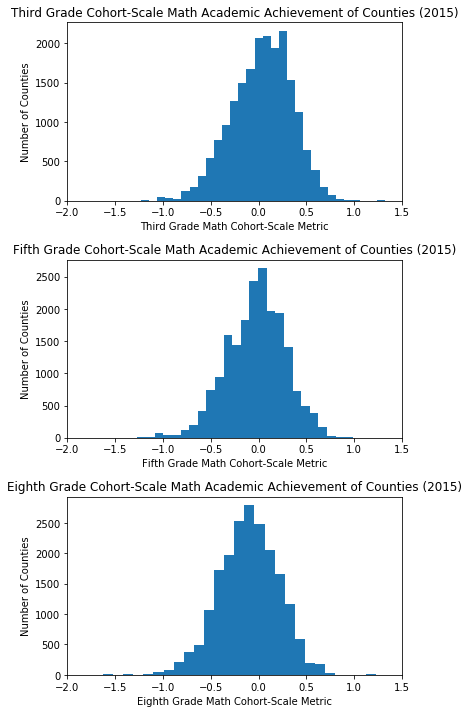

In [23]:
sub_plot = 1
plt.figure(figsize=(6,12))
plt.subplots_adjust(hspace=0.33)
frame = dc.clean_frame(frame)

# plot for each grade
for grade in grades:
  plt.subplot(3, 1, sub_plot)
  plt.hist(frame[grade + '_grade_math_scores'], bins=30)
  plt.xlim((-2, 1.5))
  plt.title(grade.capitalize()+' Grade Cohort-Scale Math Academic Achievement of Counties (2015)')
  plt.xlabel(grade.capitalize()+' Grade Math Cohort-Scale Metric')
  plt.ylabel('Number of Counties')
  sub_plot = sub_plot + 1

### Step 2B: Get county crime rate

Data Commons currently has city-level crime statistics sourced from the FBI. For example, here is the node for [crime rate in Atlanta](https://browser.datacommons.org/kg?dcid=dc/p/j57s2reqv6kk3). Once again, we will retrieve the relevant StatisticalPopulations and Observations. Note that although these statistics are from a different source, the API format remains the same and no explicit join between the datasets is needed.

Careful! Notice that for crime statistics, the population type is "CriminalActivities" instead of "Person" (see [earlier example](https://browser.datacommons.org/kg?dcid=dc/p/j57s2reqv6kk3)). A common mistake is to assume that the population type of a StatisticalPopulation is always Person.

In [0]:
# for each city, get the population of total criminal activities
frame['city_crime_pop'] = dc.get_populations(
    frame['city_dcid'],
    population_type='CriminalActivities',
    constraining_properties={
        'crimeType': 'FBI_Total'
    }
)
# observe the number of crimes in each city in 2015
frame['city_crime_count_2015'] = dc.get_observations(
    frame['city_crime_pop'],
    measured_property='count',
    stats_type='measuredValue',
    observation_date='2015',
    observation_period='P1Y'
)

We postpone aggregating city crime data into county crime data for later.

Since it would be unfair to compare crime counts of a populous county to crime counts of a deserted county, we feature engineer county crime rates by dividing the crime count by the population size. This gives us on average, how many crimes are committed per person.

To do this, we will need to know the total population in each _city_. Because we will later drop some cities, instead of just getting the county population, we will aggregate crime counts and total population of _kept cities_. Data Commons has total population data from the US Bureau of Labor Statistics.

In [25]:
# total population for each city
frame['city_pop'] = dc.get_populations(
    frame['city_dcid'],
    population_type='Person'
)
# observe the total population for each city in 2015
frame['city_pop_count_2015'] = dc.get_observations(
    frame['city_pop'],
    measured_property='count',
    stats_type='measuredValue',
    observation_date='2015',
    measurement_method='CenusACS5yrSurvey'
)

# Sample 10 rows
frame.sample(10)

,usa_dcid,county_dcid,city_dcid,third_grade_math_population,fifth_grade_math_population,eighth_grade_math_population,third_grade_math_scores,fifth_grade_math_scores,eighth_grade_math_scores,city_crime_pop,city_crime_count_2015,city_pop,city_pop_count_2015
6454,country/USA,geoId/18167,geoId/1855098,dc/p/9h248rfsw8qxh,dc/p/ggw0w40xwzznb,dc/p/1mkbge5b0n8m6,0.401105,0.325816,0.030889,,NaN,dc/p/vq5kr93cvwlh,4505.0
3885,country/USA,geoId/13089,geoId/1361040,dc/p/yhthepylp079c,dc/p/tyxb8l2nn21zf,dc/p/ecqky2tgp9ds5,-0.404060,-0.373314,-0.574254,dc/p/67wpxzemlnchg,NaN,dc/p/tn1q5t3z3lzwh,648.0
18701,country/USA,geoId/54107,geoId/5487556,dc/p/wf797b7np4s8,dc/p/zsych20b3zjbd,dc/p/s0rz69y1pfgrh,-0.034512,-0.093496,-0.212745,dc/p/nmfd048y9bs65,NaN,dc/p/nxj1gy126f9w1,2931.0
845,country/USA,geoId/02261,geoId/0252915,dc/p/h1kw8hrkbtctb,dc/p/fr8hrh91tcxe9,dc/p/1mempfmn8lje4,-0.140764,0.145605,0.016813,,NaN,dc/p/92d3g2v6ny3s7,170.0
14507,country/USA,geoId/41005,geoId/4123800,dc/p/yyxtgwrt5wbd1,dc/p/c2r681l4yjpw2,dc/p/21hefxqbh04l9,0.076843,0.170545,0.095607,dc/p/mfk1d80fe5ffh,NaN,dc/p/gxg84vlz8b7l5,2968.0
13272,country/USA,geoId/37089,geoId/3725160,dc/p/tmfbbxvtj18k2,dc/p/yk0gnmn8hj7q,dc/p/fflb57bsh4hbb,0.397469,0.339639,0.204514,,NaN,dc/p/mg97vfxbkt6l,2637.0
14261,country/USA,geoId/40113,geoId/4065300,dc/p/5ms6ks8536fx2,dc/p/dmwvjl84nb6d7,dc/p/hk587x4hfrlg8,0.080971,-0.213838,-0.538124,dc/p/453b9xgxcbvrg,764.0,dc/p/lfkbk4sndgln,19397.0
18981,country/USA,geoId/55053,geoId/5551300,dc/p/dwgqmjfsesytb,dc/p/cnl6y0xmdfg7b,dc/p/vd0c70x1n49kf,0.014837,0.113900,-0.032354,,NaN,dc/p/d4h1pv436bq2b,648.0
18655,country/USA,geoId/54087,geoId/5475820,dc/p/7ys1gnrwws6wc,dc/p/mjls3kq4dnln5,dc/p/0tjt0jyc2dzf5,-0.129020,-0.458871,-0.568192,dc/p/rzwfyvdhf2pl1,44.0,dc/p/sp80xb3x4q9z2,2014.0
18811,country/USA,geoId/55021,geoId/5502800,dc/p/1rpk7554j5j28,dc/p/e9nr7j2de62nf,dc/p/7j82ntg6w96e5,0.157114,0.343704,0.120694,,NaN,dc/p/0zw6m3dxc96g2,860.0


We now have all the necessary data. Let's keep the relevant columns.

In [26]:
# We specify keeping a subset of the columns.
data = frame[[
    'county_dcid',
    'third_grade_math_scores',
    'fifth_grade_math_scores',
    'eighth_grade_math_scores',
    'city_crime_count_2015',
    'city_pop_count_2015'
]]

# View five rows from the data.
data.sample(5)

,county_dcid,third_grade_math_scores,fifth_grade_math_scores,eighth_grade_math_scores,city_crime_count_2015,city_pop_count_2015
15443,geoId/42035,0.010859,-0.004646,-0.178015,NaN,1195.0
7911,geoId/20109,0.470006,0.434579,-0.233000,15.0,1914.0
14780,geoId/41061,-0.068322,-0.294295,-0.245349,NaN,1527.0
3435,geoId/12086,0.258250,0.018801,-0.344990,NaN,12449.0
17401,geoId/46127,0.282290,0.139696,0.250486,NaN,2080.0


Lastly, let's filter out cities with less than 50 people to reduce variance and then engineer the county crime rate feature from the remaining cities.

In [27]:
# keep cities with at least 50 people
data = data[data.city_pop_count_2015 > 50]

# for cities belonging to the same county, add crime count and pop count
county_data = (data.groupby(['county_dcid', 'eighth_grade_math_scores']).sum()
                    .reset_index()
                    .rename(columns={"city_crime_count_2015":
                                     "county_crime_count_2015",
                                     "city_pop_count_2015":
                                     "county_pop_count_2015"})
)

# divide crime count by pop count to get crime rate
county_data['county_crime_rate_2015'] = (
  county_data['county_crime_count_2015'] / county_data['county_pop_count_2015']
)

county_data.sample(5)

,county_dcid,eighth_grade_math_scores,third_grade_math_scores,fifth_grade_math_scores,county_crime_count_2015,county_pop_count_2015,county_crime_rate_2015
1238,geoId/31123,-0.170518,0.017454,0.500616,6.0,3025.0,0.001983
1615,geoId/46005,-0.021669,-4.650824,-2.812320,383.0,14591.0,0.026249
522,geoId/18089,-0.184943,5.560654,3.553264,14161.0,457984.0,0.030920
1725,geoId/47111,-0.063290,-0.190820,-1.630614,198.0,6133.0,0.032284
146,geoId/06099,-0.423100,-15.632730,-16.200900,19683.0,477563.0,0.041216


Let's look at the distribution of crime rate. Recall that crime rate means number of crimes per person on average in that year.

In [28]:
county_data[['county_crime_rate_2015']].describe()

,county_crime_rate_2015
count,1943.000000
mean,0.018849
std,0.017777
min,0.000000
25%,0.002003
50%,0.015778
75%,0.029834
max,0.126298


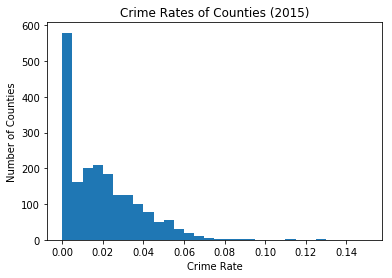

In [29]:
_ = plt.hist(county_data['county_crime_rate_2015'], range=(0.0, 0.15), bins=30)
plt.title('Crime Rates of Counties (2015)')
plt.xlabel('Crime Rate')
plt.ylabel('Number of Counties');

### Step 3: Data Analysis With Scatter Plots and Linear Regression

One way to visualize the data is to create a scatter plot of the crime rate vs the average math academic achievement.

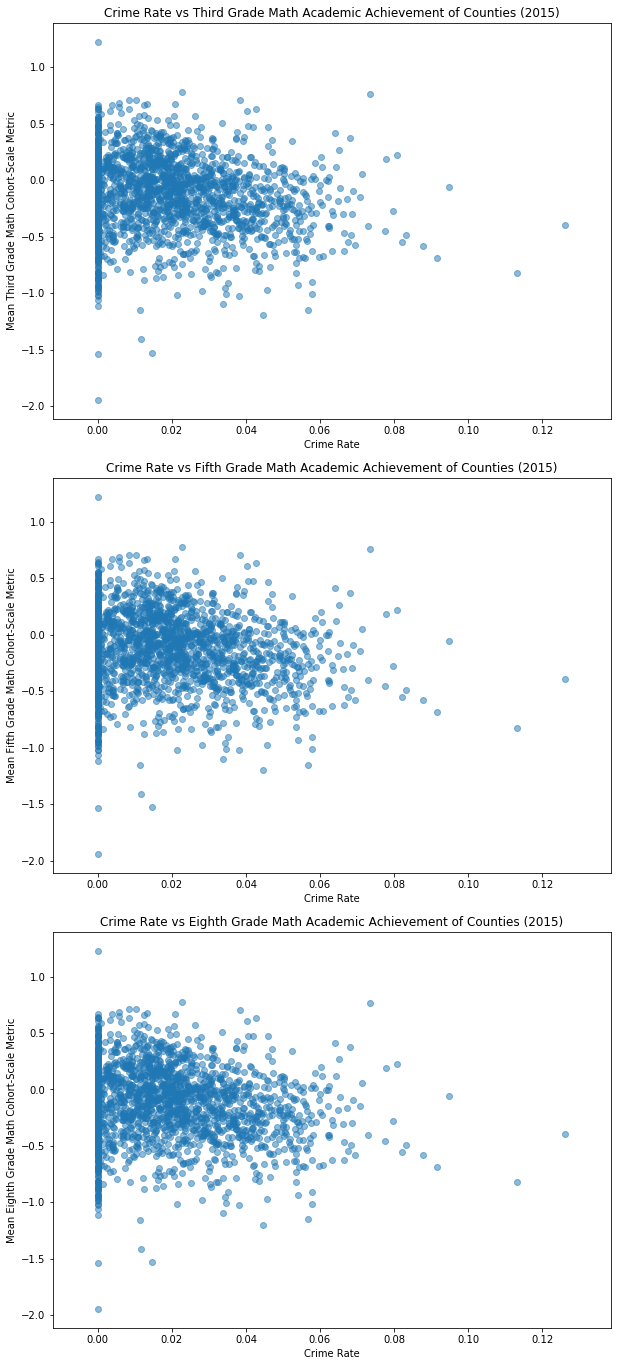

In [30]:
plt.figure(figsize=(10,24))
plt.subplots_adjust(hspace=0.15)
sub_plot = 1
for grade in grades:
  plt.subplot(3,1,sub_plot)
  plt.scatter(county_data['county_crime_rate_2015'], county_data['eighth_grade_math_scores'],
            alpha=0.5)
  plt.title('Crime Rate vs '+grade.capitalize()+' Grade Math Academic Achievement of Counties (2015)')
  plt.xlabel('Crime Rate')
  plt.ylabel('Mean '+grade.capitalize()+' Grade Math Cohort-Scale Metric');
  sub_plot = sub_plot + 1

Clearly, we have a crime rate outlier. Let's take another look with the scatter plot x-axis restricted between 0 and 0.14.

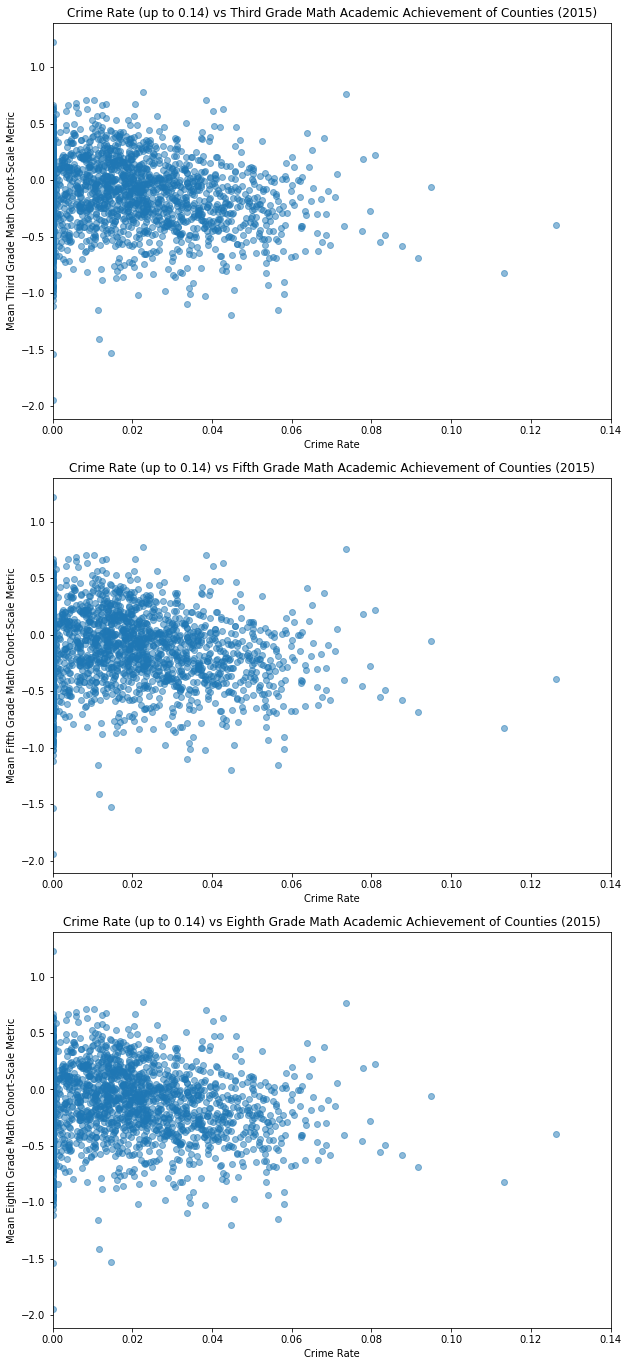

In [31]:
plt.figure(figsize=(10,24))
plt.subplots_adjust(hspace=0.15)
sub_plot = 1
for grade in grades:
  plt.subplot(3,1,sub_plot)
  plt.scatter(county_data['county_crime_rate_2015'], county_data['eighth_grade_math_scores'],
              alpha=0.5)
  plt.xlim((0, 0.14))
  plt.title('Crime Rate (up to 0.14) vs ' + grade.capitalize() + ' Grade Math Academic Achievement of Counties (2015)')
  plt.xlabel('Crime Rate')
  plt.ylabel('Mean '+grade.capitalize()+' Grade Math Cohort-Scale Metric');
  sub_plot = sub_plot + 1

The correlation appears weak, but let's check the line of best fit. We define helper functions for plotting and linear regression. We first do the analysis with the outlier, but for visualization purposes, we will continue to plot from `x=0` to `x=0.14`.

In [0]:
def linear_regression(x_values, y_values):
  model = LinearRegression(fit_intercept=True)
  model.fit(x_values.values.reshape(-1, 1), y_values)
  return model.intercept_, model.coef_, model.score(x_values.values.reshape(-1, 1), y_values)

def scatter_with_linear_regression(x_values, y_values, x_lim, x_label,
                                   y_label):
  _, ax = plt.subplots(figsize=(8,6))
  plt.xlim(x_lim)
  plt.scatter(x_values, y_values, alpha=0.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  # run linear regression
  intercept, slope, r2 = linear_regression(x_values, y_values)
  # show the corr-coeff and slope a text box in upper left in axes coords
  rounded_r2 = "{:.4f}".format(r2)
  rounded_slope = "{:.4f}".format(slope[0])
  textstr = 'slope={}\nr2={}'.format(rounded_slope, rounded_r2)
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox=props)
  plt_x_vals = np.arange(x_lim[0], x_lim[1], .01)
  # plot the line from running linear regression
  plt.plot(plt_x_vals, intercept + plt_x_vals * slope, color='red')
  plt.title(x_label + ' vs ' + y_label + ' (2015)')
  return intercept, slope

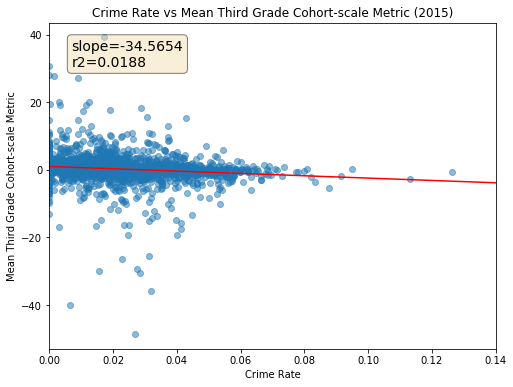

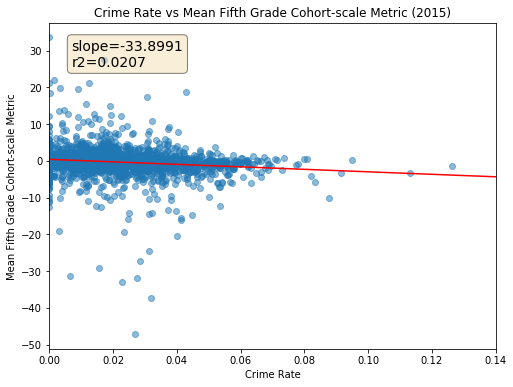

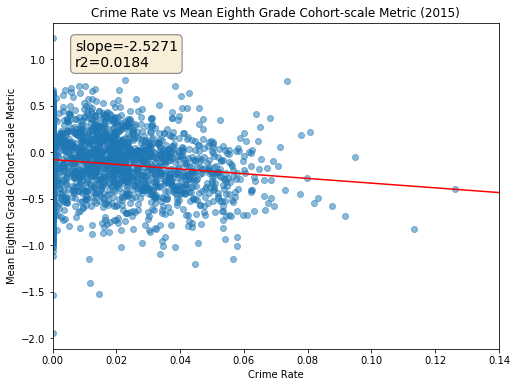

In [33]:
for grade in grades:
  scatter_with_linear_regression(
    x_values=county_data['county_crime_rate_2015'],
    y_values=county_data[grade+'_grade_math_scores'],
    x_lim=(0, 0.14),
    x_label='Crime Rate',
    y_label='Mean ' + grade.capitalize() + ' Grade Cohort-scale Metric'
  );

Indeed, we have a very weak negative correlations (r2=0.005 or less). Removing outliers (0.5% extremities) yields a similar result:

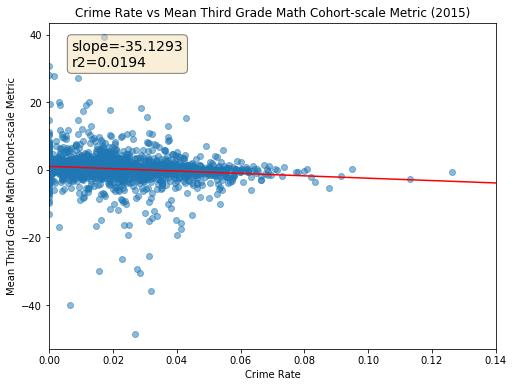

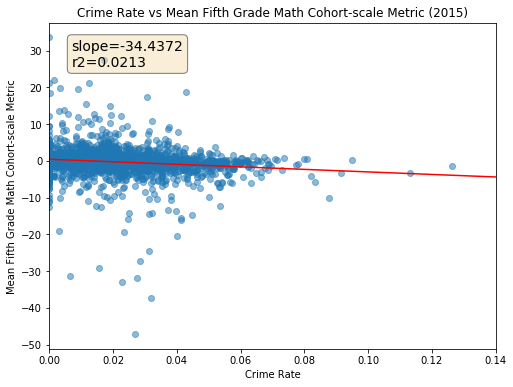

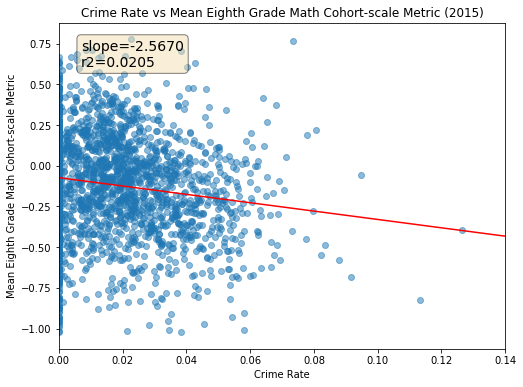

In [34]:
from scipy import stats
rm_outlier_county_data = county_data[(np.abs(stats.zscore(county_data['eighth_grade_math_scores'])) < 2.8)]

for grade in grades:
  scatter_with_linear_regression(
    x_values=rm_outlier_county_data['county_crime_rate_2015'],
    y_values=rm_outlier_county_data[grade+'_grade_math_scores'],
    x_lim=(0, 0.14),
    x_label='Crime Rate',
    y_label='Mean ' + grade.capitalize() + ' Grade Math Cohort-scale Metric' 
  );

However, we can try other possible correlates.

## Part 2: Comparing Academic Achievement Against Other Statistics

In this section, we apply the same concepts from our crime rate analysis in Part 1 to other correlates, at a faster pace.

Data Commons also has many statistics at the county level. We can use the Data Commons [browser](https://browser.datacommons.org/) as a resource for discovering available statistics. For example, the page for [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) shows statistics for the percentage of people who are male, below the poverty line, or even foreign born, provided by the US Census. Let's try these correlates.

Note that unlike crime data, these statistics are available at the county level, so we don't need to aggregate city statistics. We will simply query for county population and statistics.

This code block executes several queries and may take several minutes to run.

In [35]:
# Total population for each county
frame['county_pop'] = dc.get_populations(
    frame['county_dcid'],
    population_type='Person'
)

# Get the total population for each city in 2015
frame['county_pop_count_2015'] = dc.get_observations(
    frame['county_pop'],
    measured_property='count',
    stats_type='measuredValue',
    observation_date='2015',
    measurement_method='CenusACS5yrSurvey'
)

stats_to_query = [
  ('placeOfBirth', 'ForeignBorn'),
  ('povertyStatus', 'BelowPovertyLevelInThePast12Months'),
  ('gender', 'Male'),
]
# Get the count for each constrained population
for constraint_property, constraint_value in stats_to_query:
  # Get the column names
  pop_col = '{}_pop'.format(constraint_property)
  obs_col = '{}_obs'.format(constraint_property)
  
  # Get the populations
  frame[pop_col] = dc.get_populations(
      frame['county_dcid'],
      population_type='Person',
      constraining_properties={
          constraint_property: constraint_value
      }
  )
  
  # Get the observation
  frame[obs_col] = dc.get_observations(
      frame[pop_col],
      measured_property='count',
      stats_type='measuredValue',
      observation_date='2015',
      measurement_method='CenusACS5yrSurvey'
  )

# Sample five rows
frame.sample(5)

,usa_dcid,county_dcid,city_dcid,third_grade_math_population,fifth_grade_math_population,eighth_grade_math_population,third_grade_math_scores,fifth_grade_math_scores,eighth_grade_math_scores,city_crime_pop,city_crime_count_2015,city_pop,city_pop_count_2015,county_pop,county_pop_count_2015,placeOfBirth_pop,placeOfBirth_obs,povertyStatus_pop,povertyStatus_obs,gender_pop,gender_obs
4886,country/USA,geoId/17053,geoId/1723425,dc/p/15e287s0g32y,dc/p/zff04w15k0909,dc/p/2rl8shhkdyv53,0.270564,0.260630,0.270943,,NaN,dc/p/76cv9mh9wklm,239.0,dc/p/0s7wnr4rl06q1,13835.0,dc/p/vfv65fhqerrqg,141.0,dc/p/qtpr266k8b6t9,1790.0,dc/p/smh8e60txrg33,6854.0
4244,country/USA,geoId/13263,geoId/1349532,dc/p/2wzywl6b0br8g,dc/p/2emd3ep0wf0p4,dc/p/j5xwwlgfgmz99,-0.384810,-0.638081,-0.544954,dc/p/z4ceyegl32pch,142.0,dc/p/kdtfdbh1ydpb8,4141.0,dc/p/lqvsy9rdrcc53,6490.0,dc/p/00swvk847nx4b,56.0,dc/p/21hj65htqzt9g,1291.0,dc/p/gsh7pw0e1djg3,3140.0
10448,country/USA,geoId/26121,geoId/2613820,dc/p/bxnmnzvzyjxld,dc/p/p87yjy5nwypw4,dc/p/31f7h7z7q4qvb,-0.287133,-0.329599,-0.397756,,NaN,dc/p/yefdqd8hm3pd2,457.0,dc/p/bfffjld19kmhc,171483.0,dc/p/smrgsbgpdhkt,2754.0,dc/p/l5wlh5t4hp221,31550.0,dc/p/nnkk7t63p01vc,85094.0
4326,country/USA,geoId/13303,geoId/1365156,dc/p/hbj6d8dfvzy97,dc/p/6x1hjxb5lbe4b,dc/p/zmyszlz6hn144,-0.218242,-0.341400,-0.674130,,NaN,dc/p/vtdxp1ggsxmt9,58.0,dc/p/ncz7wwzc7gdh,20785.0,dc/p/t5s5e556qfg4f,328.0,dc/p/t5w223mwf9l59,4961.0,dc/p/68b00sxvf518h,10467.0
11316,country/USA,geoId/27119,geoId/2739050,dc/p/jc3czymy2e4vd,dc/p/xgm0qsmcj7bmh,dc/p/970dedlhex8cd,0.311078,0.287133,0.043535,,NaN,dc/p/0r40v337n868d,537.0,dc/p/k8lqg8r4pf9m5,31547.0,dc/p/8mwxtbvxsw9j8,753.0,dc/p/w4fjk1kk221qg,3987.0,dc/p/ch2y7xymw76tg,15940.0


We now have all the necessary data. Let's transform our DCFrame to a pandas dataframe, keeping only relevant columns.

In [36]:
data = frame[
    [
        'third_grade_math_scores',
        'fifth_grade_math_scores',
        'eighth_grade_math_scores',
        'county_pop_count_2015',
    ] + [
        constraint_prop + '_obs' for (constraint_prop, _) in stats_to_query
    ]
]

data.sample(5)

,third_grade_math_scores,fifth_grade_math_scores,eighth_grade_math_scores,county_pop_count_2015,placeOfBirth_obs,povertyStatus_obs,gender_obs
19281,0.206025,0.280157,0.212927,62992.0,1761.0,7656.0,31578.0
17300,-0.537891,-0.931497,-0.422460,2086.0,12.0,921.0,1042.0
18907,0.176477,0.370539,0.331903,101920.0,3450.0,9071.0,49914.0
15988,-0.042000,-0.124130,-0.335840,320095.0,17415.0,48822.0,157486.0
5891,0.334672,-0.053472,-0.168602,32835.0,2025.0,4504.0,16165.0


Lastly, let's filter out counties with less than 50 people to reduce variance. We once again normalize counts by population size.

In [37]:
# keep counties with at least 50 people
data = data[data.county_pop_count_2015 > 50]

# convert the place of birth, poverty status, and gender counts to percentages
for (constraint_property, _) in stats_to_query:
  data['{}_obs_percentage'.format(constraint_property)] = 100 * (
      data['{}_obs'.format(constraint_property)] / data['county_pop_count_2015']
  )
  # no longer need the count
  data.drop('{}_obs'.format(constraint_property), axis=1, inplace=True)
# no longer need the county population
data.drop('county_pop_count_2015', axis=1, inplace=True)
data.sample(10)

,third_grade_math_scores,fifth_grade_math_scores,eighth_grade_math_scores,placeOfBirth_obs_percentage,povertyStatus_obs_percentage,gender_obs_percentage
9364,0.337117,0.337711,-0.122737,2.759838,5.778236,49.376346
14634,-0.734729,-0.693193,-0.637518,7.048638,19.754318,51.280540
245,-0.188680,-0.298294,-0.661327,2.694524,19.349305,48.384827
11431,0.590499,0.438614,0.707080,2.697979,7.705667,50.952976
16382,0.129757,0.154997,0.084400,1.189575,13.931984,49.649986
16130,0.538057,0.588467,0.432948,10.176513,6.436892,48.573502
3326,0.227512,0.035383,-0.176323,15.468716,15.846009,48.993559
19352,0.679265,0.350436,0.113135,1.409889,12.285478,51.091448
17575,-0.289896,-0.602005,-0.536116,0.576752,28.076013,49.445430
18238,-0.134520,0.164471,0.358472,4.136889,14.993001,50.139984


We now plot all of the data as inidividual scatter plots.

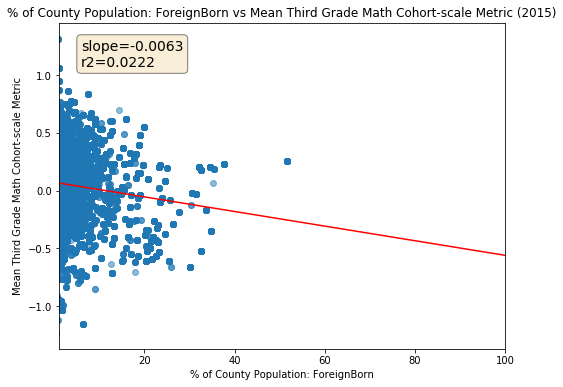

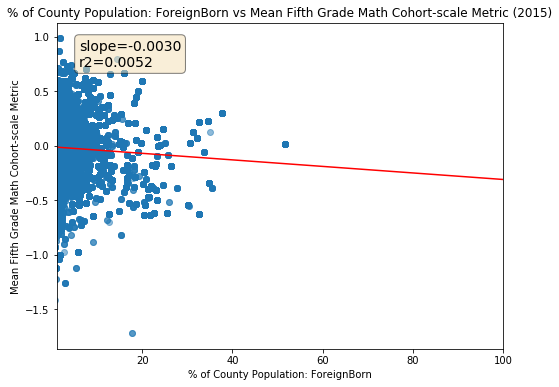

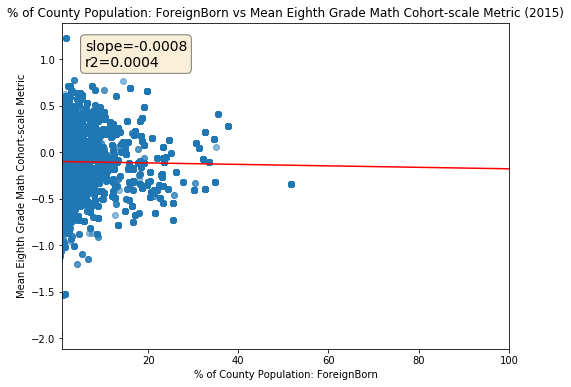

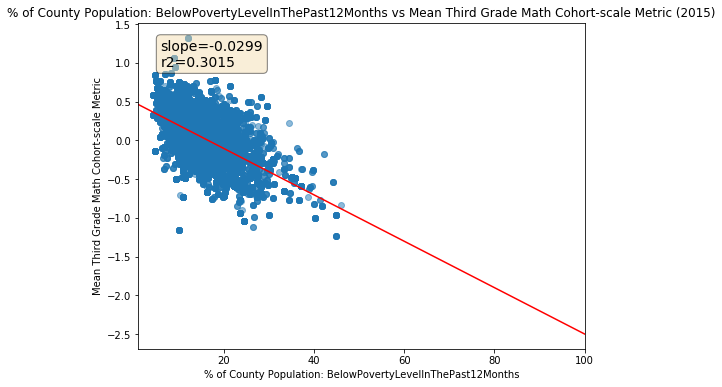

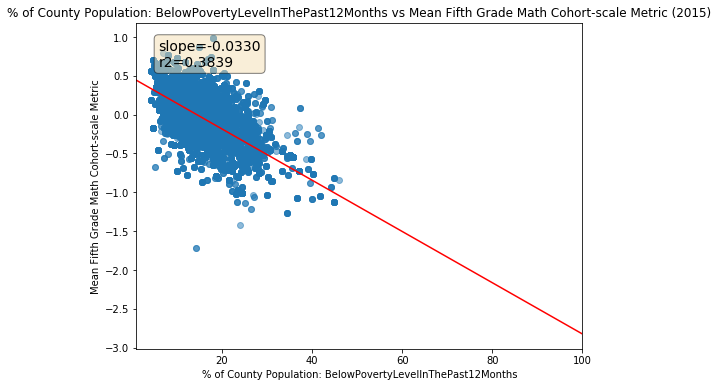

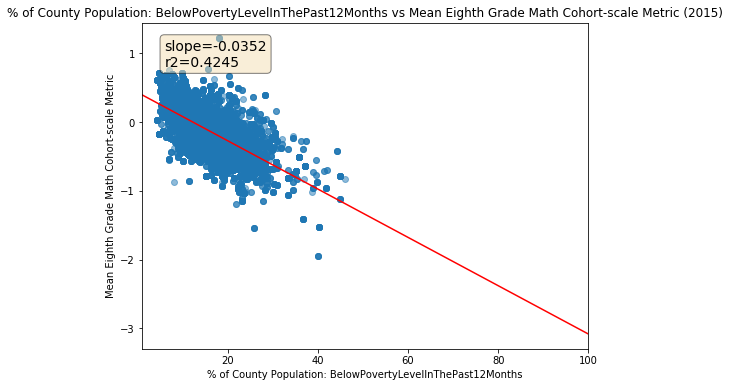

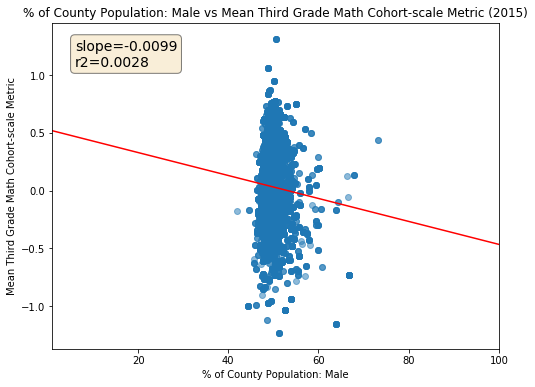

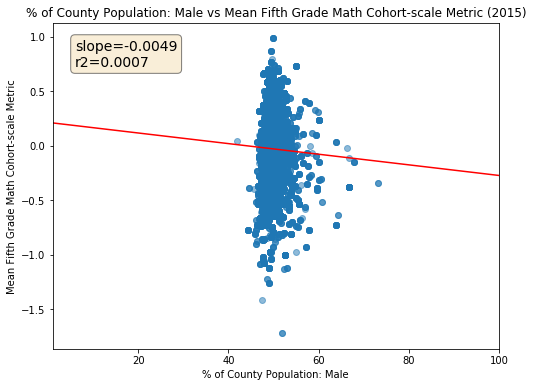

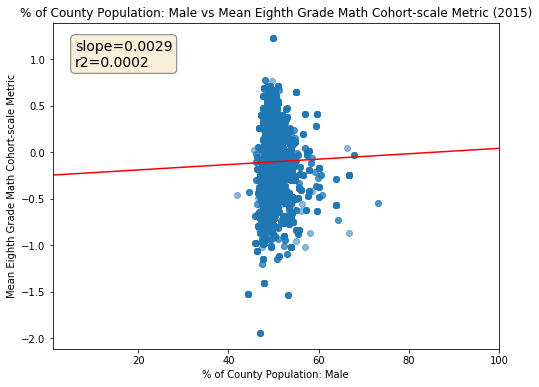

In [38]:
for (constraint_property, constraint_value) in stats_to_query:
  for grade in grades:
    scatter_with_linear_regression(
      x_values=data['{}_obs_percentage'.format(constraint_property)],
      y_values=data[grade+'_grade_math_scores'],
      x_lim=(1, 100),
      x_label='% of County Population: {}'.format(constraint_value),
      y_label='Mean ' + grade.capitalize() + ' Grade Math Cohort-scale Metric'
    );
  

It appears that the percentage of people below the poverty line in the county is a fairly strong negative correlate with math academic achievement (r2=0.26 to r2=0.41). Furthermore, It looks like as grade level increases, not only does the slope become increasingly negative, but the explained variance (r2) also increases. This indicates that the correlation between the city poverty rate and academic achievement in math does grow stronger as students progress through the system.

In 2017, Loudoun County had a poverty rate of 3.0%, compared to Ziebach County's poverty rate of 56.7% ([source: US Census](https://www.census.gov/data-tools/demo/saipe/#/?map_geoSelector=aa_c)). This means we can easily talk about 10% increases in poverty rate. The slope of -0.035 would translate to an expected 0.350 decrease in 8th grade math cohort-scale academic achievement per 10% increase in poverty rate--non negligible considering cohort-scale metric's narrow range. However, we have to be careful not to assume causation. There could be confounding factors involved.

For the curious, we include a pairplot of the 3 math scores and 3 county statistics. This may help you compare the plots from above.

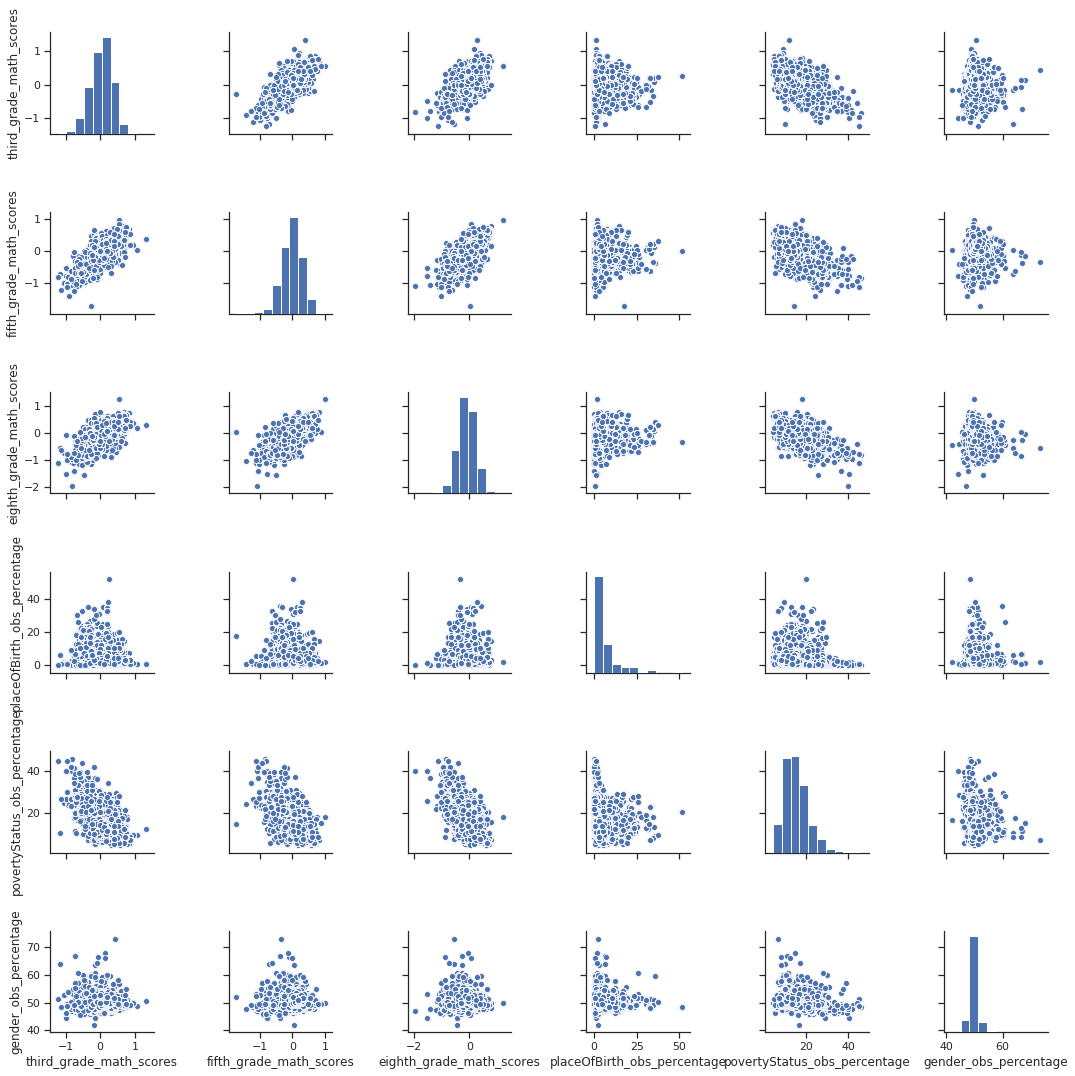

In [39]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data)

## Conclusion
In this colab, we learned how Data Commons organizes data into entities, StatisticalPopulations, and Observations, and how to use the Python API to query for them. These queries returned statistics from the SEDA dataset and other data sources, such as the FBI, Bureau of Labor Statistics, and US Census. Instead of spending time joining the different datasets together, we saw that Data Commons provides a unified interface to many datasets to get exactly what you need. This allowed us to quickly discover that the correlation between crime rate and academic achievement is very weak.

We moved on to find possible correlations between 8th grade math academic achievement and other county-level population statistics such as percentage male, percentage foreign-born, and poverty rate. We found poverty rate to be the strongest correlate. Finally, we drilled into how the correlation between poverty rate and academic achievement changes progresses through grade levels and found that the correlation grows stronger as students progress through school.

The county statistics we correlated with are only a fraction of what is available in Data Commons. Can you find any other county statistics that correlate well with academic achievement?